# Analyzing and Comparing LLM-Consolidated Bug Explanations
This notebook demonstrates how to:
1. Load and filter answers from real programmers (the "human" answers).
2. Consolidate their explanations by Question.ID.
3. Use one or more LLM prompts to generate a "consolidated" explanation.
4. Compute BLEU and ROUGE metrics comparing each human answer to the LLM answer.
5. Visualize and analyze how different prompts might affect these scores.

## Background on Metrics
- **BLEU** (Bilingual Evaluation Understudy) is typically between 0.0 and 1.0,
  with values closer to 1.0 indicating higher overlap with the reference text.
- **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) provides
  overlaps in terms of recall, precision, and F-score for n-grams (1-gram, 2-gram)
  and longest common subsequence (rouge-l).
  - The `'rouge-1'` entry focuses on unigrams (single-word overlap),
  - `'rouge-2'` on bigrams,
  - `'rouge-l'` uses the longest common subsequence approach.

**Note**: A low BLEU or ROUGE doesn't necessarily mean the LLM's answer is "bad";
it might just use different wording or more concise phrasing. However, these metrics do give a rough idea of textual similarity to the human-written answers.

In [1]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
load_dotenv()

from openai import OpenAI
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

## 1. Load & Filter Data

In [2]:
data = pd.read_csv("answerList_data.csv")

# Filter to include only rows where TP == 1 or TN == 1
filtered_data = data[(data["TP"] == 1) | (data["TN"] == 1)]

print("Filtered data shape:", filtered_data.shape)

Filtered data shape: (1629, 25)


## 2. Group Explanations by Question.ID
We'll create a single string for each question's human explanations,
separated by newlines, so we can pass them to the LLM as a single "prompt."

In [4]:
grouped_explanations = (
    filtered_data
    .groupby("Question.ID")["Answer.explanation"]
    .apply(lambda explanations: "\n".join(str(x) for x in explanations if pd.notnull(x)))
    .reset_index(name="human_consolidated_explanations")
)

display(grouped_explanations)

,Question.ID,human_consolidated_explanations
0,0,hoursOffset accepts negative numbers between -...
1,1,Minutes are set to -15; which is less then 0 a...
2,2,The conditional checks if hours and minutes ar...
3,3,These line don't apply. \nhour range is 0 to 2...
4,4,the conditional clause throws an error if the ...
...,...,...
124,124,It seems as though the program is fed an inval...
125,125,Although I've never used this library; looking...
126,126,Because char at 5 != '_' and the conditions ab...
127,127,Line 121; 122 check if the input locale is in ...


## 3. Define LLM Client & Generate Consolidated Explanations

In [6]:
# Create the client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def get_llm_consolidation(explanations_text, prompt_text):
    """
    Given a batch of human explanations (explanations_text) and a prompt_text,
    calls the LLM to generate a consolidated explanation.
    """
    # Build a full prompt, combining the "prompt_text" plus the actual lines
    full_prompt = f"""{prompt_text}

Here are the explanations each separated by a newline:
{explanations_text}
    """
    try:
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": full_prompt}],
            model="gpt-4o-mini", 
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("OpenAI API call failed:", e)
        return None

### 3.1 Example: Testing Multiple Prompts
We can define a list (or dict) of prompts and create separate consolidated answers.
Let's illustrate with two different prompts, "Prompt A" and "Prompt B", for instance.

In [7]:
PROMPTS = {
    "Prompt_A": """I have a dataset of code bug report explanations. There were unit test failures that were given to programmers together with the code. The programmers then should explain the problem in the code. Your task is to consolidate the answers of the programmers into a single explanation by merging the programmers’ explanations in a way that minimizes redundant information, while keeping the information that would be necessary for someone else to fix the bug.""",

    "Prompt_B": """Programmers have provided bug explanations. 
Your goal is to unify them into a single, clear explanation that keeps necessary 
technical details but avoids repeating the same info. Provide a short summary 
focusing on the steps needed to fix the bug.""",

    "Prompt_C": """Combine the following bug explanations into one cohesive 
report. Minimize repetition, but ensure all crucial details needed for 
another developer to fix the bug are included. The final explanation 
should remain concise (ideally under 150 words)."""
}

# Create new dataframe that stores the LLM outputs for each question & each prompt
llm_results = []

for prompt_name, prompt_text in PROMPTS.items():
    temp_df = grouped_explanations.copy()
    temp_df["LLM_prompt"] = prompt_name  # track which prompt we used

    # Generate the consolidated text for each question
    temp_df["LLM_consolidated_explanation"] = temp_df["human_consolidated_explanations"].apply(
        lambda text: get_llm_consolidation(text, prompt_text)
    )
    llm_results.append(temp_df)

# Concatenate results for all prompts
grouped_explanations_all_prompts = pd.concat(llm_results, ignore_index=True)

In [8]:
grouped_explanations_all_prompts.to_csv("grouped_explanations_all_prompts.csv", index=False)
grouped_explanations_all_prompts.head()

,Question.ID,human_consolidated_explanations,LLM_prompt,LLM_consolidated_explanation
0,0,hoursOffset accepts negative numbers between -...,Prompt_A,The explanations indicate that the `hoursOffse...
1,1,Minutes are set to -15; which is less then 0 a...,Prompt_A,The issue arises from the handling of the `min...
2,2,The conditional checks if hours and minutes ar...,Prompt_A,The issue in the code arises from an exception...
3,3,These line don't apply. \nhour range is 0 to 2...,Prompt_A,The issue at hand is related to an input valid...
4,4,the conditional clause throws an error if the ...,Prompt_A,The bug in the code arises from the handling o...


## 4. Merge the LLM Explanations Back to the Original (Filtered) Data
We want each human answer to line up with the LLM's consolidated explanation (now, one per Question.ID, *per prompt*).
So we'll do an INNER MERGE on both Question.ID and LLM_prompt.

In [9]:
filtered_data_merged = filtered_data.merge(
    grouped_explanations_all_prompts[["Question.ID", "LLM_prompt", "LLM_consolidated_explanation"]],
    on="Question.ID",
    how="inner"  # or "left" but "inner" ensures we only keep rows that have a match
)

print("Merged shape:", filtered_data_merged.shape)
filtered_data_merged.to_csv("filtered_data_merged.csv", index=False)
filtered_data_merged.head()

Merged shape: (4887, 27)


,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,LLM_prompt,LLM_consolidated_explanation
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,Prompt_A,The explanations indicate that the `hoursOffse...
1,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,Prompt_B,The bug involves an issue with minutesOffset r...
2,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,Prompt_C,The bug report indicates a problem unrelated t...
3,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,Prompt_A,The explanations indicate that the `hoursOffse...
4,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,Prompt_B,The bug involves an issue with minutesOffset r...


## 5. Compute BLEU & ROUGE for Each Human Answer vs. LLM Answer
We'll do the exact same loop as before, but now we have multiple prompts in the data.

In [10]:
rouge = Rouge()

bleu_scores = []
rouge_scores = []

for idx, row in filtered_data_merged.iterrows():
    human_answer = str(row["Answer.explanation"])
    llm_answer = str(row["LLM_consolidated_explanation"])

    # (1) BLEU
    reference_tokens = [human_answer.split()]  # single reference
    candidate_tokens = llm_answer.split()
    bleu_val = sentence_bleu(reference_tokens, candidate_tokens)
    bleu_scores.append(bleu_val)

    # (2) ROUGE
    # returns: [{'rouge-1': {...}, 'rouge-2': {...}, 'rouge-l': {...}}]
    scores = rouge.get_scores(llm_answer, human_answer)[0]
    rouge_scores.append(scores)

filtered_data_merged["BLEU_score"] = bleu_scores
filtered_data_merged["ROUGE_score"] = rouge_scores

/Users/raphael/miniforge3/envs/aip-porsche/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/raphael/miniforge3/envs/aip-porsche/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/raphael/miniforge3/envs/aip-porsche/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

## 6. Analyze & Visualize
We'll define helper functions to parse the ROUGE dict and produce summary stats and plots.

=== Overall BLEU ===
count     4.887000e+03
mean      4.857649e-03
std       1.534795e-02
min       0.000000e+00
25%      8.493667e-232
50%      2.334295e-155
75%       6.304022e-79
max       2.145165e-01
Name: BLEU_score, dtype: float64

=== Overall ROUGE-1-F ===
count    4887.000000
mean        0.139801
std         0.080801
min         0.000000
25%         0.079208
50%         0.133333
75%         0.192771
max         0.451613
Name: ROUGE_1_F, dtype: float64

=== Overall ROUGE-2-F ===
count    4887.000000
mean        0.028330
std         0.032245
min         0.000000
25%         0.000000
50%         0.018182
75%         0.042032
max         0.254902
Name: ROUGE_2_F, dtype: float64

=== Overall ROUGE-L-F ===
count    4887.000000
mean        0.126283
std         0.072926
min         0.000000
25%         0.072727
50%         0.119048
75%         0.172043
max         0.411765
Name: ROUGE_L_F, dtype: float64

=== Grouped by LLM_prompt ===


BLEU_score                          ROUGE_1_F                 \
                 mean       std  min       max      mean       std  min   
LLM_prompt                                                                
Prompt_A     0.005839  0.015198  0.0  0.140548  0.134708  0.078844  0.0   
Prompt_B     0.003904  0.014835  0.0  0.214516  0.136748  0.079938  0.0   
Prompt_C     0.004830  0.015939  0.0  0.157014  0.147947  0.082985  0.0   

                     ROUGE_2_F                          ROUGE_L_F            \
                 max      mean       std  min       max      mean       std   
LLM_prompt                                                                    
Prompt_A    0.408163  0.030850  0.032491  0.0  0.254902  0.123463  0.072313   
Prompt_B    0.434783  0.025022  0.031233  0.0  0.252747  0.122324  0.071379   
Prompt_C    0.451613  0.029119  0.032734  0.0  0.218978  0.133062  0.074616   

                           
            min       max  
LLM_prompt                 
Prompt_A    0.0  0.404762  
Prompt_B    0.0  0.411765  
Prompt_C    0.0  0.400000

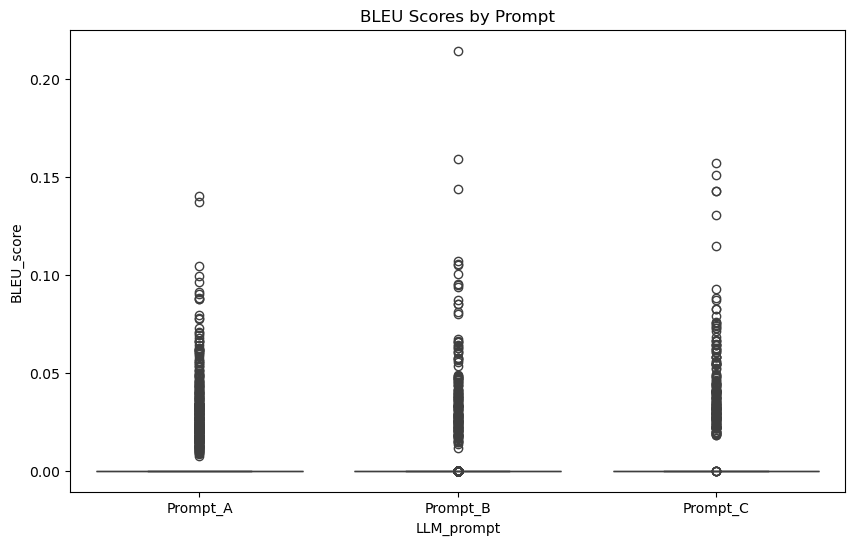

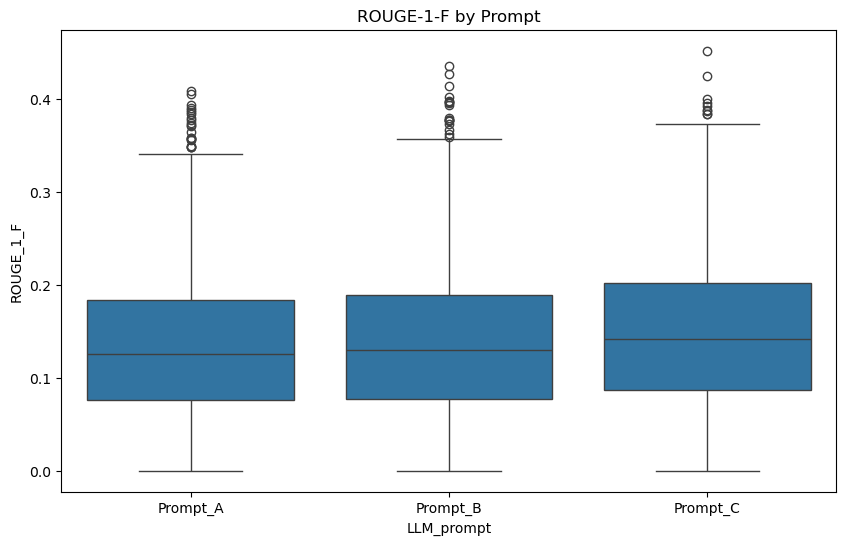

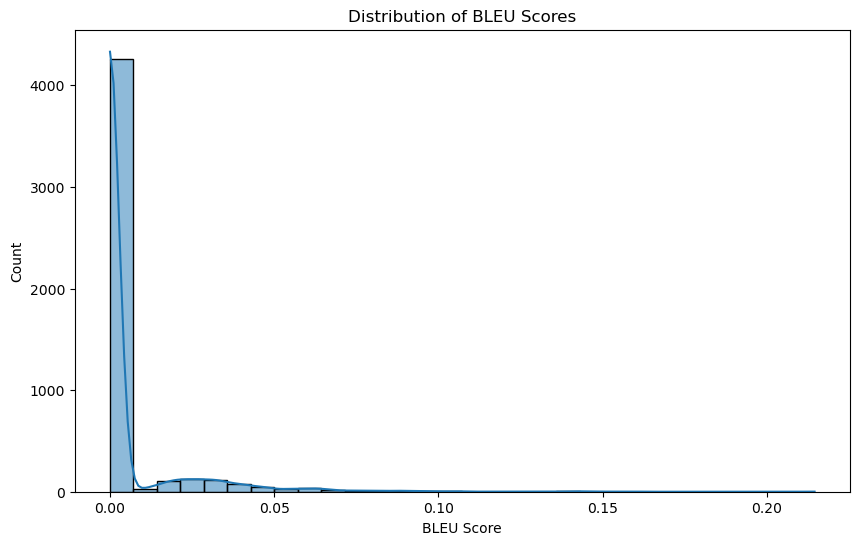

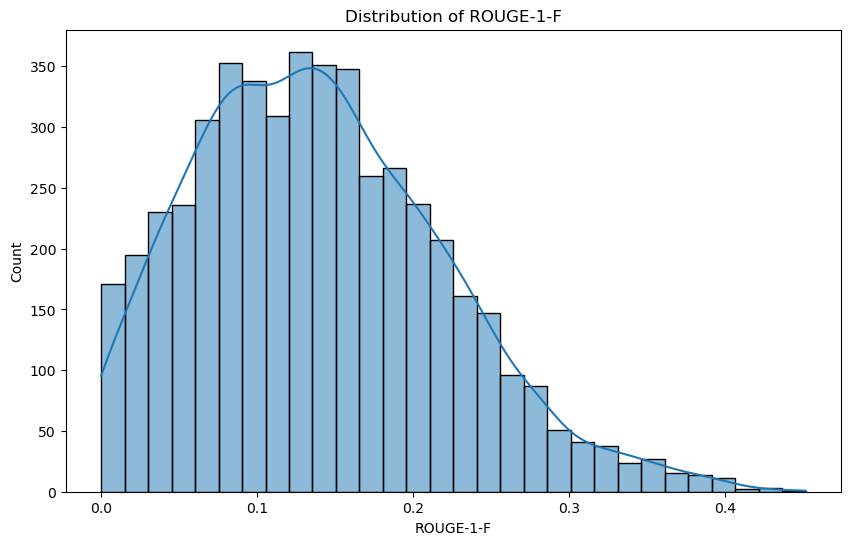

In [11]:
def extract_rouge_f(rouge_dict, metric="rouge-1"):
    """
    Safely get the 'f' score from the metric within a ROUGE dictionary.
    E.g. metric='rouge-1', 'rouge-2', or 'rouge-l'.
    """
    return rouge_dict.get(metric, {}).get("f", None)

def analyze_and_visualize_scores(df, group_col="LLM_prompt"):
    """
    df: DataFrame with columns 'BLEU_score' (float) and 'ROUGE_score' (dict),
        plus a column indicating which prompt or group each row belongs to.
    group_col: column to group by for comparisons (default "LLM_prompt").
    """

    # We expect df["ROUGE_score"] to be a list/dict of format:
    # {'rouge-1': {...}, 'rouge-2': {...}, 'rouge-l': {...}}
    df["ROUGE_1_F"] = df["ROUGE_score"].apply(lambda x: extract_rouge_f(x, "rouge-1"))
    df["ROUGE_2_F"] = df["ROUGE_score"].apply(lambda x: extract_rouge_f(x, "rouge-2"))
    df["ROUGE_L_F"] = df["ROUGE_score"].apply(lambda x: extract_rouge_f(x, "rouge-l"))

    # 6.1 Basic stats
    print("=== Overall BLEU ===")
    print(df["BLEU_score"].describe())
    print("\n=== Overall ROUGE-1-F ===")
    print(df["ROUGE_1_F"].describe())
    print("\n=== Overall ROUGE-2-F ===")
    print(df["ROUGE_2_F"].describe())
    print("\n=== Overall ROUGE-L-F ===")
    print(df["ROUGE_L_F"].describe())

    # 6.2 Grouped Analysis (by LLM_prompt or other column)
    os.makedirs("plots", exist_ok=True)
    if group_col in df.columns:
        print(f"\n=== Grouped by {group_col} ===")
        grouped = df.groupby(group_col).agg({
            "BLEU_score": ["mean", "std", "min", "max"],
            "ROUGE_1_F": ["mean", "std", "min", "max"],
            "ROUGE_2_F": ["mean", "std", "min", "max"],
            "ROUGE_L_F": ["mean", "std", "min", "max"],
        })
        display(grouped)

        # Boxplot for BLEU
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=group_col, y="BLEU_score", data=df)
        plt.title("BLEU Scores by Prompt")
        plt.savefig("plots/boxplot_bleu_by_prompt.png", dpi=300, bbox_inches="tight")
        plt.show()

        # Boxplot for ROUGE-1-F
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=group_col, y="ROUGE_1_F", data=df)
        plt.title("ROUGE-1-F by Prompt")
        plt.savefig("plots/boxplot_rouge1F_by_prompt.png", dpi=300, bbox_inches="tight")
        plt.show()
    else:
        print(f"Column '{group_col}' not found, skipping group analysis.")

    # 6.3 Distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(df["BLEU_score"], kde=True, bins=30)
    plt.title("Distribution of BLEU Scores")
    plt.xlabel("BLEU Score")
    plt.ylabel("Count")
    plt.savefig("plots/hist_bleu_score.png", dpi=300, bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(df["ROUGE_1_F"], kde=True, bins=30)
    plt.title("Distribution of ROUGE-1-F")
    plt.xlabel("ROUGE-1-F")
    plt.ylabel("Count")
    plt.savefig("plots/hist_rouge1F_score.png", dpi=300, bbox_inches="tight")
    plt.show()

### 6.4 Run the Analysis
analyze_and_visualize_scores(filtered_data_merged, group_col="LLM_prompt")


# 7. Reflection
- Different prompt styles give us notably different consolidation strategies, which impacts readability and text overlap scores.
- Because LLMs paraphrase heavily, the n-gram overlap may be low despite the summary still covering the key points. (Low BLEU Does Not Equate to Low Quality)
- Sometimes crucial details might be missing if the LLM does not consider them essential. Humans might have to be involved.
- LLM might introduce extraneous or incorrect details (risk of hallucination)
- Prompt Engineering can increase focus on important bug details and reduce redundant or irrelevant information